In [50]:
%matplotlib inline

import pandas
import seaborn
import multiprocessing
from functools import partial

import pgdata

db = pgdata.connect()

In [51]:
# create table to hold slope values
db['temp.salmon_slopes'].drop()
sql = """
  CREATE TABLE temp.salmon_slopes
    (linear_feature_id integer,
    blue_line_key integer, 
    downstream_route_measure double precision, 
    watershed_group_code text,
    slope numeric)
"""
db.execute(sql)
db.execute("CREATE INDEX ON temp.salmon_slopes (linear_feature_id)")

LBIR
LNIC
OKAN
TSAY


In [52]:
def _parallel_tiled(db_url, sql, block, n_subs=2):
    """
    Create a connection and execute query for specified block.
    n_subs is the number of places in the sql query that should be
    substituted by the block id

    this should live in pgdata
    """
    # create a new connection
    db = pgdata.connect(db_url, multiprocessing=True)
    # As we are explicitly splitting up our job we don't want the database to try
    # and manage parallel execution of these queries within these connections.
    # Turn off this connection's parallel execution for pg version >= 10:
    version_string = db.query('SELECT version()').fetchone()[0]
    major_version_number = int(version_string.split(' ')[1].split('.')[0])
    if major_version_number >= 10:
        db.execute("SET max_parallel_workers_per_gather = 0")
    print(block)
    db.execute(sql, (block,) * n_subs)

In [53]:
slope_sql = """
-- join events to streams based on blkey and measures
WITH unbroken_segments AS (
  SELECT
    s.linear_feature_id,
    e.blue_line_key,
    s.downstream_route_measure as line_measure,
    s.length_metre,
    e.species_codes,
    ST_LineMerge((ST_Dump(s.geom)).geom) as geom
  FROM temp.fishdistrib_events e
  INNER JOIN  whse_basemapping.fwa_stream_networks_sp s
  ON e.blue_line_key = s.blue_line_key
  AND abs(e.downstream_route_measure - round(s.downstream_route_measure::numeric, 3)) < .01
  AND abs(e.upstream_route_measure - round(s.upstream_route_measure::numeric, 3)) < .01
  WHERE e.species_codes && ARRAY['CH', 'CM', 'CO', 'PK', 'SK']
  AND s.watershed_group_code = %s
),

end_segments AS (
  SELECT * FROM (
    SELECT
      s.linear_feature_id,
      e.blue_line_key,
      s.downstream_route_measure as line_measure,
      e.upstream_route_measure - e.downstream_route_measure AS length_metre,
      e.species_codes,
      ST_LineSubstring(
        ST_LineMerge((ST_Dump(s.geom)).geom),
        0,
        -- there are a very small number of records that return very small negative
        -- values - an invalid input for st_linesubstring - set to zero with GREATEST
        GREATEST(ROUND(
                   CAST((e.upstream_route_measure  - s.downstream_route_measure)
                          / s.length_metre AS NUMERIC),
                   5
                ),
                0)
      ) AS geom
    FROM temp.fishdistrib_events e
    INNER JOIN  whse_basemapping.fwa_stream_networks_sp s
    ON e.blue_line_key = s.blue_line_key
    AND abs(e.downstream_route_measure - round(s.downstream_route_measure::numeric, 3)) < .01
    AND e.upstream_route_measure < round(s.upstream_route_measure::numeric, 3)
    -- double check that this line hasn't already been added as an unbroken segment
    -- by joining back
    LEFT OUTER JOIN unbroken_segments u
    ON s.linear_feature_id = u.linear_feature_id
    WHERE e.species_codes && ARRAY['CH', 'CM', 'CO', 'PK', 'SK']
    AND s.watershed_group_code = %s
    AND u.linear_feature_id IS NULL
    ) AS lines
  WHERE ST_Length(geom) > 1
),

-- lump everything together
lines AS
(
  SELECT * FROM unbroken_segments
  UNION ALL
  SELECT * from end_segments
),

vertices AS
(
  SELECT
    linear_feature_id,
    blue_line_key,
    line_measure,
    length_metre,
    (ST_LineLocatePoint(
         geom,
         ST_PointN(geom,
                   generate_series(1,
                                   ST_NPoints(geom)
                   )
        )
       ) * length_metre
     ) + line_measure AS vertex_measure
FROM lines
),

meas AS
(
  SELECT DISTINCT
    linear_feature_id,
    blue_line_key,
    line_measure,
    round(vertex_measure::numeric, 8) as vertex_measure
  FROM vertices
  WHERE vertex_measure IS NOT NULL
),

slopes AS
(SELECT
  linear_feature_id,
  blue_line_key,
  vertex_measure as downstream_route_measure,
  fwa_slopewindow(blue_line_key, vertex_measure, 100) AS slope
FROM meas
)

INSERT INTO temp.salmon_slopes (linear_feature_id, blue_line_key, downstream_route_measure, watershed_group_code, slope)
SELECT linear_feature_id, blue_line_key, downstream_route_measure, %s, slope FROM slopes
ORDER BY blue_line_key, linear_feature_id, downstream_route_measure"""

In [54]:
# get distinct watershed groups
sql = "SELECT DISTINCT watershed_group_code FROM whse_fish.fiss_fish_obsrvtn_events ORDER BY watershed_group_code"
groups = [g[0] for g in db.query(sql).fetchall()]

# process by group for speed
func = partial(_parallel_tiled, db.url, slope_sql, n_subs=3)
pool = multiprocessing.Pool(processes=4)
pool.map(func, groups)
pool.close()
pool.join()

print('Slope calculations complete')

ADMS
BRKS
COLR
FINA
COMX
FINL
FIRE
FONT
FOXR
FRAN
BULK
COTR
FRCN
ALBN
FROG
GATA
GLAR
ATLL
GOLD
ATNA
GRAI
BABL
COWN
BULL
CAMB
BABR
CANO
CARP
CARR
CHES
CRKD
CRYL
DEAD
CHIL
DEAL
DEAR
DOGC
BARR
BBAR
GRNL
GUIC
HARR
CHIR
HAYR
HERR
DRIR
CHUK
CHWK
DUNC
DUNE
HOLB
ELKR
EUCH
CLAY
HOMA
EUCL
KINR
CLRH
CLWR
KISK
KISP
HORS
COAL
BEAV
INGR
INKR
LBIR
LBTN
LCHL
BELA
BIGC
BLAR
ISKR
JENR
JERV
LCHR
KITL
KAHN
KAKC
KCHL
KEEC
BLUR
KETL
BONP
KHOR
KHTZ
LNIC
KITR
LDEN
KLAR
KLIN
LEUT
LFRA
LNRS
LNTH
BOWR
LFRT
KLUM
LOMI
LPCE
LHAF
LIAR
LPET
LPRO
LRAN
LRDO
LSAL
LSIK
LSKE
LILL
KNIG
KOTL
KOTR
KSHR
BRID
MCGR
KTSU
LSTR
KUMR
LISR
KUSR
LARL
LKEC
MURT
MUSK
LKEL
LTRE
NAHR
MAHD
MBNK
OKAN
LMUS
OSPK
OWIK
LNAR
PARA
PARK
PARS
PCEA
SALR
MDEA
MESC
MESI
PINE
PITR
PORI
QUES
NAKR
MFRA
REVL
NARC
SAHD
SAHT
SAJR
SALM
STUL
STUR
NASC
SUST
MFRT
NASR
MIDR
SANJ
MILL
MMUS
MORI
SWIR
SETN
NATR
NAZR
TABR
MORK
NBNK
NECL
NECR
NEVI
SEYM
NICL
TAHR
SHEK
SHER
TAHS
TAKL
TASR
NIEL
TATR
NIMP
TSAY
SHUL
TAYR
TESR
TSEA
TSIT
SIML
SKGT
SLOC
SMAR
SMOK
SPAT
SQAM


In [ ]:
# create a table holding all distinct salmon species observations
# and the max slope downstream of that observation
sql = """CREATE TABLE temp.salmon_slopes_max AS
WITH slopes AS
(
  SELECT
    a.linear_feature_id,
    a.blue_line_key,
    a.downstream_route_measure,
    s.wscode_ltree,
    s.localcode_ltree,
    s.
    a.slope
  FROM temp.salmon_slopes a
  INNER JOIN whse_basemapping.fwa_stream_networks_sp s
  ON a.linear_feature_id = s.linear_feature_id
),

slopes_dnstr AS (
SELECT
    a.fish_obsrvtn_distinct_id,
    b.slope
FROM whse_fish.fiss_fish_obsrvtn_events a
INNER JOIN slopes b
ON b.linear_feature_id != a.linear_feature_id AND
        (
          -- donwstream criteria 1 - same blue line, lower measure
          (b.blue_line_key = a.blue_line_key AND
           b.downstream_route_measure <= a.downstream_route_measure)
          OR
          -- criteria 2 - watershed code a is a child of watershed code b,
          -- (but not equal, that has to be handled by the blue line)
          (b.wscode_ltree @> a.wscode_ltree
              AND b.wscode_ltree != a.wscode_ltree
              AND (
                   -- local code is lower or wscode and localcode are equivalent
                   (
                    b.localcode_ltree < subltree(a.localcode_ltree, 0, nlevel(b.localcode_ltree))
                    OR b.wscode_ltree = b.localcode_ltree
                   )
                   -- OR any missed side channels on the same watershed code
                   OR (b.wscode_ltree = a.wscode_ltree AND
                       b.blue_line_key != a.blue_line_key AND
                       b.localcode_ltree < a.localcode_ltree)
                   )
          )
      )
WHERE a.species_codes && ARRAY['CH', 'CM', 'CO', 'PK', 'SK']
UNION ALL
SELECT
    a.fish_obsrvtn_distinct_id,
    b.slope
FROM whse_fish.fiss_fish_obsrvtn_events a
INNER JOIN slopes b
ON b.linear_feature_id = a.linear_feature_id AND
b.downstream_route_measure < a.downstream_route_measure
WHERE a.species_codes && ARRAY['CH', 'CM', 'CO', 'PK', 'SK']),

slopes_by_spp AS (
    SELECT DISTINCT
      s.*,
      unnest(e.species_codes) as species_code
    FROM slopes_dnstr s
    INNER JOIN whse_fish.fiss_fish_obsrvtn_events e
    ON s.fish_obsrvtn_distinct_id = e.fish_obsrvtn_distinct_id

)

SELECT
  obs.fish_obsrvtn_distinct_id,
  sp.name AS species_name,
  max(obs.slope) as max_slope_dnstr
FROM slopes_by_spp obs
INNER JOIN whse_fish.species_cd sp ON obs.species_code = sp.code
WHERE species_code in ('CH', 'CM', 'CO', 'PK', 'SK')
GROUP BY obs.fish_obsrvtn_distinct_id, sp.name"""

db.execute(sql)

In [55]:
# load slopes to pandas
sql = "SELECT * FROM temp.salmon_slopes_max"
salmon_slopes = pandas.read_sql_query(sql, db.engine)
salmon_slopes.head()

,fish_obsrvtn_distinct_id,species_name,max_slope_dnstr
0,40109,Coho Salmon,3.87
1,19988,Coho Salmon,12.40
2,24950,Coho Salmon,11.64
3,9816,Pink Salmon,1.75
4,5231,Pink Salmon,0.84


In [56]:
salmon_slopes.describe()

,fish_obsrvtn_distinct_id,max_slope_dnstr
count,25882.000000,25874.000000
mean,23104.111661,6.246990
std,17523.551893,7.061032
min,5.000000,0.000000
25%,8217.250000,2.950000
50%,19033.500000,4.470000
75%,36569.750000,7.220000
max,68367.000000,138.630000


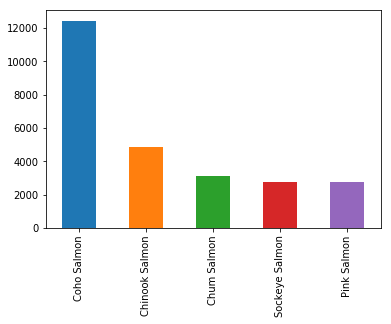

In [58]:
# how many observations per species?
pandas.value_counts(salmon_slopes['species_name']).plot.bar()

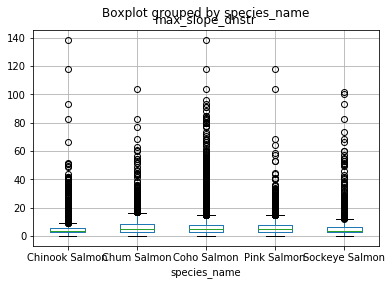

In [60]:
# try box plot
salmon_slopes.boxplot(column='max_slope_dnstr', by='species_name')

In [61]:
# how many slope values are over 40%?
len(salmon_slopes[salmon_slopes['max_slope_dnstr'] > 40])

189

In [62]:
# and less than 40?
len(salmon_slopes[salmon_slopes['max_slope_dnstr'] <= 40])

25685

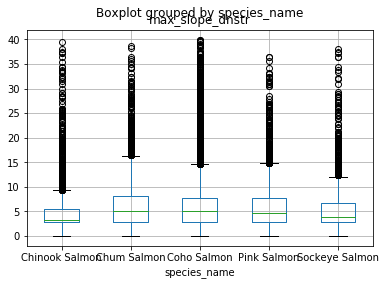

In [63]:
# lets just throw out everything over 40%, presuming it is an error
lt40 = salmon_slopes[salmon_slopes['max_slope_dnstr'] <= 40]
lt40.boxplot(column='max_slope_dnstr', by='species_name')